In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy
import scipy
import math
import matplotlib
import matplotlib.dates as mpd
import pylab as plt
import datetime as dtm
import pytz
import multiprocessing as mpp
import pickle
import sys
import os
import socket
import h5py
#import lmod
# lmod.load('system')
# lmod.load('texlive')
# lmod.
#
# TODO: phase out unreferenced hpc_lib calls...
import hpc_lib
import hpc_reports
#
# def running_mean(X,n=10):
#     return (numpy.cumsum(numpy.insert(X,0,0))[n:] - numpy.cumsum(numpy.insert(X,0,0))[:-n])/n
# #
import platform
print('** platform: ', platform.node() )

import socket
print('hostname: ', socket.gethostname() )

** platform:  UIT-C02YT0LBLVDP.local
hostname:  UIT-C02YT0LBLVDP.local


## GPU Count integration

Integrate GPU counts into jobs_summary, so instead of having a seperate method to extract and cound GPUs, we count them during calc_jobs_summary(). This should also give more accurate count (???), in the event that it is possible to miss a GPU request for  a job where the request occurs in a later step. I actually don't think this is possible; the first line of the job group should always have the full allocation, which will include the GPUs, but just in case something strange happens...

NOTE: Since this involves actual computation of jobs_summary, it has to be run on Sherlock (or similar)... or could be done from a downloaded data file, but we don't really want to do that...


In [3]:
n_cpus = 4
print('** epoch: {}'.format(mpd.get_epoch()))
print('*** ')

** epoch: 1970-01-01T00:00:00
*** 


In [4]:
N_report_len = 180
end_dtm = dtm.datetime(2022,7,6)
end_date = end_dtm.date()
start_date = end_date - dtm.timedelta(days=N_report_len)
print('*** dates: {} - {}'.format(start_date, end_date))
partition='serc'
#partition=None
group=None
s_user=None
verbose=0
# group='oneillm'
# group='edunham'
#s_user = 'labraha2'
#
sacct_h5_file = f'sacct_data/sacct_p{str(partition).upper()}_g{str(group).upper()}_u{s_user}_{start_date.year:04}{start_date.month:02}{start_date.day:02}_{end_dtm.year:04}{end_dtm.month:02}{end_dtm.day:02}.h5'
print(f'*** sacct_h5_file: {sacct_h5_file}')
print(f'*** h5_file exists: {os.path.isfile(sacct_h5_file)}')

*** dates: 2022-01-07 - 2022-07-06
*** sacct_h5_file: sacct_data/sacct_pSERC_gNONE_uNone_20220107_20220706.h5
*** h5_file exists: True


In [5]:
# NOTE: to get individual users, eg to get Eric's group usage:
#. sacct --allusers --user=labraha2 --start=2022-01-01 --end=2022-06-15
#
# NOTE: additional options can be passed in the more_options=[] arrary, or just as sacct_{option-name}={val}
#
if os.path.isfile(sacct_h5_file):
    print('*** Creating SACCT object from HDF5 {}'.format(sacct_h5_file))
    SACCT_obj = hpc_lib.SACCT_data_from_h5(sacct_h5_file, keep_raw_data=False, n_cpu=n_cpus)
    #
    
else:
    print('*** Fetching SACCT data directly')
    SACCT_obj = hpc_lib.SACCT_data_direct(group=group, partition=partition, start_date=str(start_date),
                                          n_cpu=n_cpus, verbose=verbose,
                                          end_date=str(end_date), keep_raw_data=False)
    # , sacct_user=s_user
    print(f'** writing HDF5: {sacct_h5_file}')
    SACCT_obj.write_hdf5(sacct_h5_file)
    #
#
print('** ', SACCT_obj.jobs_summary.dtype.names)

*** Creating SACCT object from HDF5 sacct_data/sacct_pSERC_gNONE_uNone_20220107_20220706.h5
**  ('index', 'User', 'Group', 'GID', 'JobName', 'JobID', 'JobIDRaw', 'Partition', 'State', 'Timelimit', 'NCPUS', 'NNodes', 'Submit', 'Eligible', 'Start', 'End', 'Elapsed', 'SystemCPU', 'UserCPU', 'TotalCPU', 'NTasks', 'CPUTimeRAW', 'Suspended', 'ReqTRES', 'AllocTRES', 'MaxRSS', 'AveRSS', 'AveVMSize', 'MaxVMSize', 'MaxDiskWrite', 'MaxDiskRead', 'AveDiskWrite', 'AveDiskRead', 'JobID_parent', 'NGPUs')


In [6]:
# print('** ', SACCT_obj.jobs_summary.dtype.descr)
# dtp = [(n, t[0] if isinstance(t,tuple) else t) for n,t in SACCT_obj.jobs_summary.dtype.descr ]

# #
# ZZ = numpy.zeros( shape=(100, ), dtype=dtp)
# ZZ = SACCT_obj[0:100]
# print('** ', ZZ[0:10])

# # check date epoch:
# dt_test = SACCT_obj.jobs_summary['Start'][0]
# yr_test = mpd.num2date(dt_test).year
# print(f'** yr_test: {yr_test}')
# #print('** ', mpd.num2epoch(dt_test))
# if yr_test>3000:
#     mpd.set_epoch('0000-12-31T00:00:00')
# yr_test = mpd.num2date(dt_test)
# print(f'** yr_test: {yr_test}')

In [7]:
cpuh_layers = SACCT_obj.get_cpu_hours_layer_cake(bin_size=1., layer_field='Group',
                                                 t_max=mpd.date2num(end_date) )

### CPU-Hours, Jobs layer cake + Pie charts.
- Fist, the semi-manual construction. Uses some consolidated functions (eg, _layer_cake() and plot_pie() )
- Then, these all wrapped up into one line or data + figures setup, then one line.

/Users/myoder96/Codes/HPC_analytics/hpc_lib.py:3199: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(lbls)
/Users/myoder96/Codes/HPC_analytics/hpc_lib.py:3199: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(lbls)


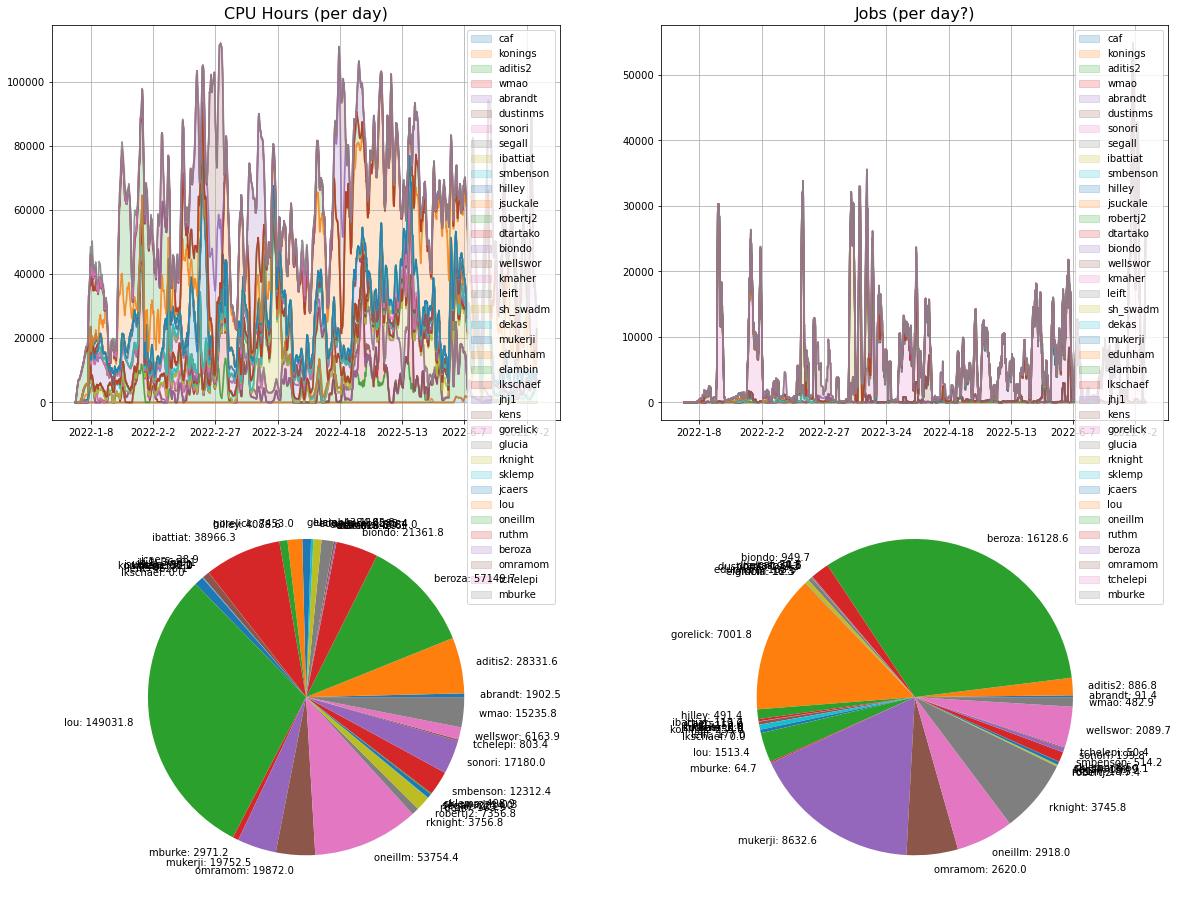

In [8]:
fg = plt.figure(figsize=(20,16))
ax1 = fg.add_subplot(2,2,1)
ax2 = fg.add_subplot(2,2,2)
ax3 = fg.add_subplot(2,2,3)
ax4 = fg.add_subplot(2,2,4)
ax1.grid()
ax2.grid()
#
ax1.set_title('CPU Hours (per day)', size=16)
ax2.set_title('Jobs (per day?)', size=16)
#
#cpuh_layers = SACCT_obj.get_cpu_hours_layer_cake(bin_size=1., layer_field='Group')
group_by = 'Group'
cpuh = cpuh_layers['cpu_hours']
jobs = cpuh_layers['jobs']
T = cpuh['time']
#
z_cpuh = hpc_lib.plot_layer_cake(data=cpuh, layers=cpuh.dtype.names[1:], time_col='time', ax=ax1)
z_jobs = hpc_lib.plot_layer_cake(data=jobs, layers=cpuh.dtype.names[1:], time_col='time', ax=ax2)
#
pie_cpuh_data = hpc_lib.plot_pie(sum_data=SACCT_obj['Elapsed']*SACCT_obj['NCPUS'],
                                slice_data=SACCT_obj[group_by], ax=ax3
                                )
#pi_slices = ax.pie(pi_slices[:,1], labels=pi_slices[:,0])
pie_jobs_data = hpc_lib.plot_pie(sum_data=SACCT_obj['Elapsed'], slice_data=SACCT_obj[group_by], 
                            ax=ax4)
#
ax1.legend(loc=0)
ax2.legend(loc=0)
#


/Users/myoder96/Codes/HPC_analytics/hpc_lib.py:3199: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(lbls)
/Users/myoder96/Codes/HPC_analytics/hpc_lib.py:3199: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(lbls)


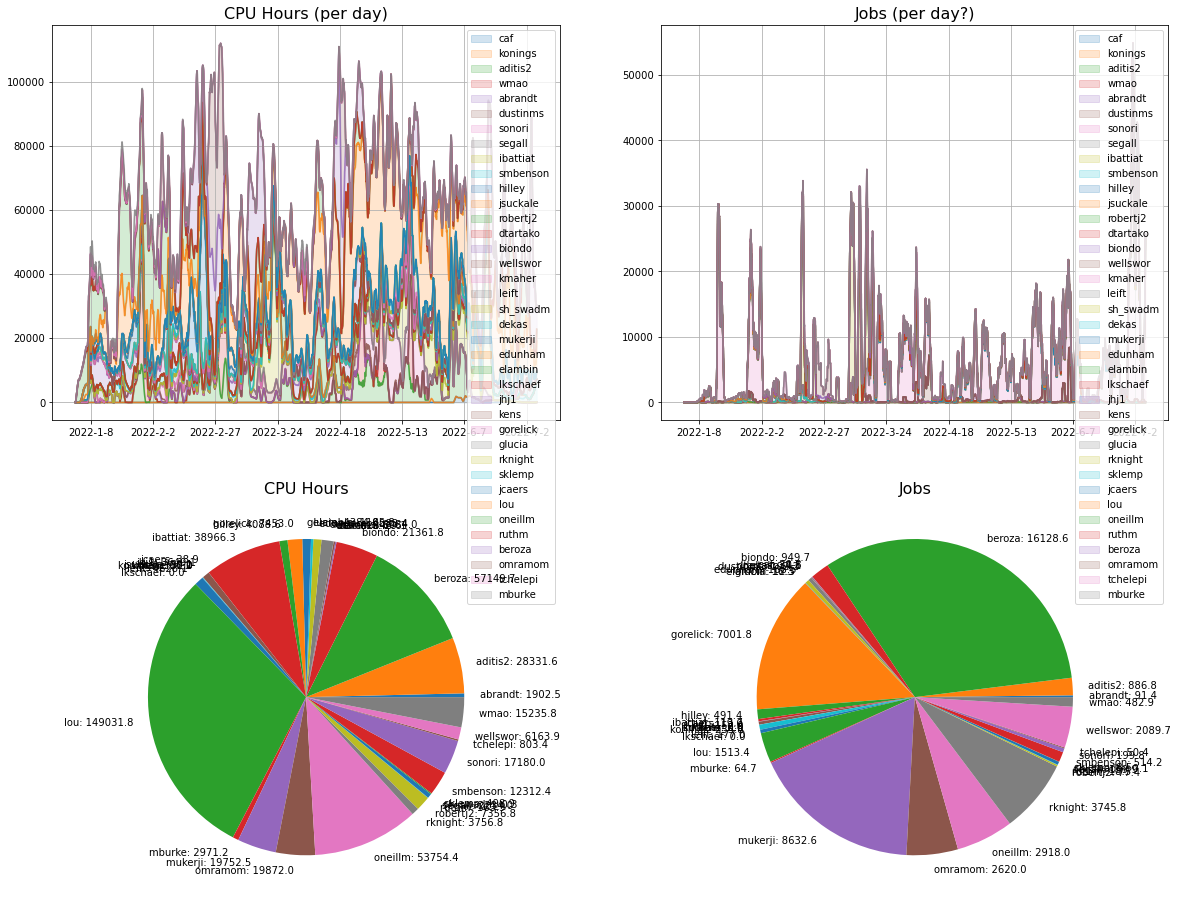

In [9]:
fg = plt.figure(figsize=(20,16))
ax1 = fg.add_subplot(2,2,1)
ax2 = fg.add_subplot(2,2,2)
ax3 = fg.add_subplot(2,2,3)
ax4 = fg.add_subplot(2,2,4)

zz = SACCT_obj.report_cpuhours_jobs_layercake_and_pie(fg=fg, cpuh_jobs=cpuh_layers)

*** DEBUG t_now: 19202.646438585303, t_max: 19181.523136574073


/Users/myoder96/Codes/HPC_analytics/hpc_lib.py:3199: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(lbls)
/Users/myoder96/Codes/HPC_analytics/hpc_lib.py:3199: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(lbls)


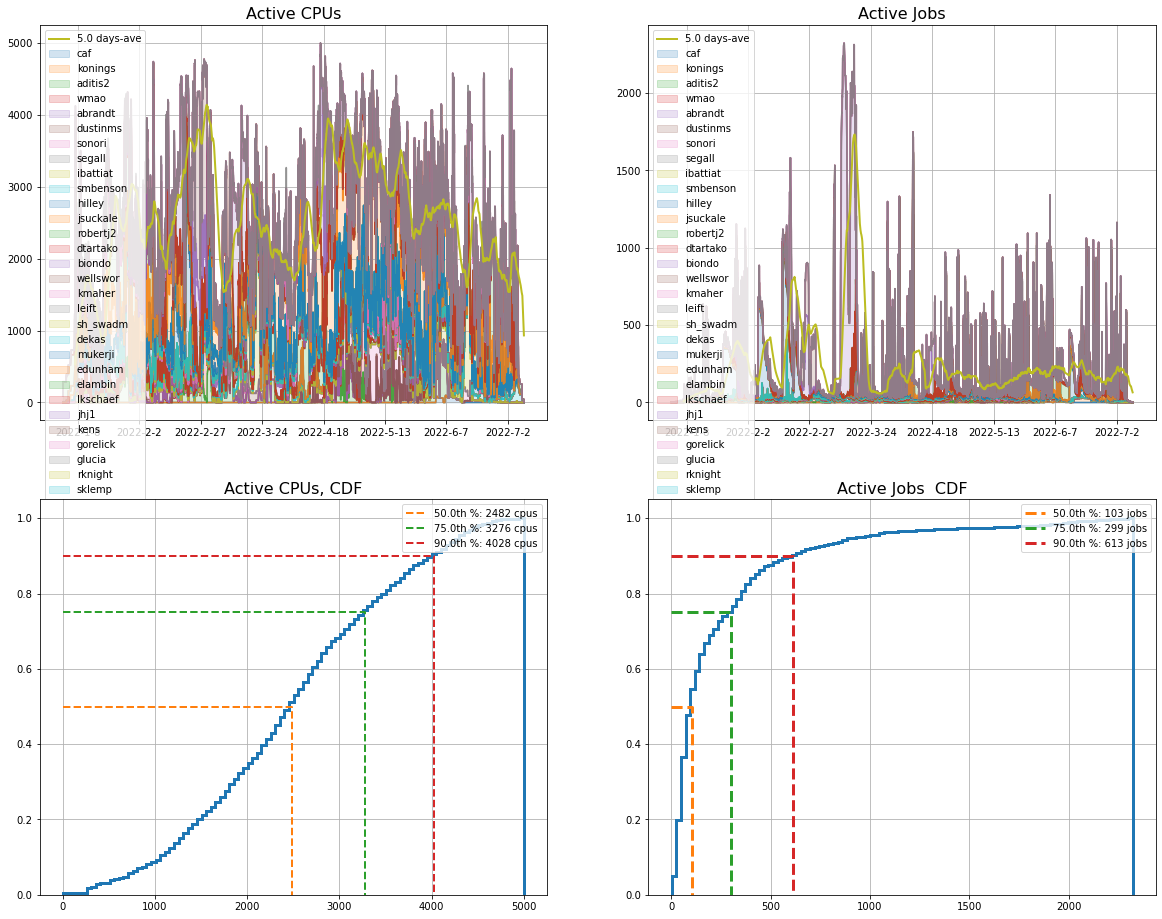

In [13]:
qq = SACCT_obj.report_activecpus_jobs_layercake_and_CDFs(n_points=5000,
                        group_by='Group', acpu_layer_cake=None)
# acpu_layer_cake


/Users/myoder96/Codes/HPC_analytics/hpc_lib.py:1200: UserWarning: FixedFormatter should only be used together with FixedLocator
  tmp_x = ax.set_xticklabels(['', *[str(int((x%24)/daily_Period) ) for x in ax.get_xticks()[1:]]])


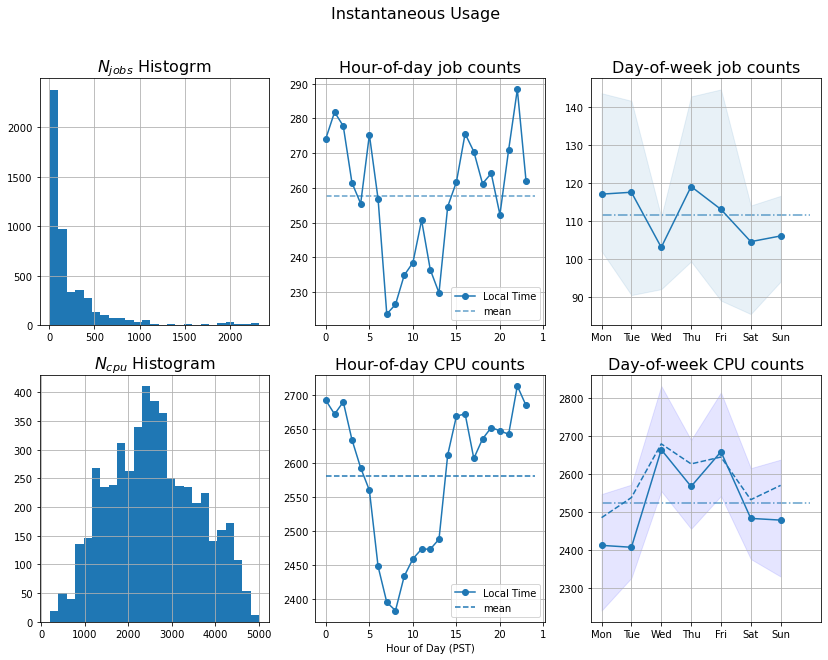

In [14]:
zz = SACCT_obj.active_cpu_jobs_per_day_hour_report()

### Mazama GPU activity

In [ ]:
# maz_h5 = 'sacct_data/sacct_pNONE_gNONE_uNone_20211222_20220620.h5'
# SACCT_maz = SACCT_obj = hpc_lib.SACCT_data_from_h5(maz_h5, keep_raw_data=False, n_cpu=n_cpus)

# # serc_gpu_activity = SACCT_serc.active_jobs_cpu(jobs_summary=None, bin_size=1., 
# #                                                NCPUs=SACCT_serc.get_NGPUs())

# gpu_layers = SACCT_maz.get_active_cpus_layer_cake(layer_field='Partition', NCPUs=SACCT_serc.get_NGPUs())

# # For MAZAMA
# #
# pi_gpu_grps = [s for s in gpu_layers['N_cpu'].dtype.names[1:]]
# print(f'** {pi_gpu_lbls}' )
# #
# NGPU = SACCT_serc.get_NGPUs()
# #
# #pi_gpu_vals = numpy.zeros(len(pi_gpu_lbls))
# pi_gpu_vals = []
# pi_gpu_lbls = []
# for k,g in enumerate(pi_gpu_grps):
#     ix = SACCT_serc.jobs_summary['Group'].astype(str)==g
#     #
#     n_gpus = numpy.sum(SACCT_serc.jobs_summary['Elapsed'][ix] * NGPU[ix])
#     if n_gpus <= 0.:
#         continue
#     #
#     pi_gpu_vals += [n_gpus]
#     pi_gpu_lbls += [f'{g}: {pi_gpu_vals[-1]:.1f}']
# #
# print('** vals: ', pi_gpu_vals)
# #pi_gpu_lbls = [f'{s}: {v:.1f}' for s,v in zip(pi_gpu_lbls, pi_gpu_vals) ]


# fg = plt.figure(figsize=(18,16))
# ax1 = fg.add_subplot(2,1,1)
# ax2 = fg.add_subplot(2,2,3)
# ax3 = fg.add_subplot(2,2,4)
# ax1.grid()
# #ax2.grid()
# ax3.grid()
# #
# hpc_lib.plot_layer_cake(gpu_layers['N_cpu'], ax=ax1)
# z_gpus = ax1.lines[-1].get_ydata()
# qs = [.5, .75, .9]
# qs_gpu = numpy.quantile(z_gpus, qs)
# #
# print('*** keys(): ', gpu_layers.keys())
# ax2.pie(pi_gpu_vals, labels=pi_gpu_lbls) 
# ax2.legend(loc=0)
# #
# hh_cpus = ax3.hist(z_gpus, bins=100, cumulative=True, density=True, histtype='step', lw=3.)
# for x,y in zip(qs_gpu, qs):
#     #ax3.plot([0., qs_cpus[-1], qs_cpus[-1]], [qs[-1], qs[-1], 0.], ls='--', color='r', lw=2. )
#     ax3.plot([0., x, x], [y, y, 0.], ls='--', lw=2., label=f'{y*100.}th %: {x:.0f} gpus' )

# ax1.set_title('Active GPUs', size=16)
# ax3.legend(loc=0)

### SERC GPU activity

In [ ]:
# serc_h5 = 'sacct_data/serc_sacct_20211126_20220525.h5'
# SACCT_serc = hpc_lib.SACCT_data_from_h5(serc_h5, keep_raw_data=False, n_cpu=n_cpus)

serc_gpu_activity = SACCT_obj.active_jobs_cpu(jobs_summary=None, bin_size=1., 
                                               NCPUs=SACCT_obj.get_NGPUs())

In [ ]:
gpu_layers = SACCT_obj.get_active_cpus_layer_cake(layer_field='Group',
                        NCPUs=SACCT_obj.get_NGPUs(), t_max=mpd.date2num(dtm.datetime(2022,7,6)))

In [ ]:
pi_gpu_grps = [s for s in gpu_layers['N_cpu'].dtype.names[1:]]
#
NGPU = SACCT_obj.get_NGPUs()
#
#pi_gpu_vals = numpy.zeros(len(pi_gpu_lbls))
pi_gpu_vals = []
pi_gpu_lbls = []
for k,g in enumerate(pi_gpu_grps):
    ix = SACCT_obj.jobs_summary['Group'].astype(str)==g
    #
    n_gpus = numpy.sum(SACCT_obj.jobs_summary['Elapsed'][ix] * NGPU[ix])
    if n_gpus <= 0.:
        continue
    #
    pi_gpu_vals += [n_gpus]
    pi_gpu_lbls += [f'{g}: {pi_gpu_vals[-1]:.1f}']
#
print('** vals: ', pi_gpu_vals)
print(f'** {pi_gpu_lbls}' )
#pi_gpu_lbls = [f'{s}: {v:.1f}' for s,v in zip(pi_gpu_lbls, pi_gpu_vals) ]


fg = plt.figure(figsize=(18,16))
ax1 = fg.add_subplot(2,1,1)
ax2 = fg.add_subplot(2,2,3)
ax3 = fg.add_subplot(2,2,4)
ax1.grid()
#ax2.grid()
ax3.grid()
#
hpc_lib.plot_layer_cake(gpu_layers['N_cpu'], ax=ax1)
z_gpus = ax1.lines[-1].get_ydata()
qs = [.5, .75, .9]
qs_gpu = numpy.quantile(z_gpus, qs)
#
print('*** keys(): ', gpu_layers.keys())
ax2.pie(pi_gpu_vals, labels=pi_gpu_lbls) 
ax2.legend(loc=0)
#
hh_cpus = ax3.hist(z_gpus, bins=100, cumulative=True, density=True, histtype='step', lw=3.)
for x,y in zip(qs_gpu, qs):
    #ax3.plot([0., qs_cpus[-1], qs_cpus[-1]], [qs[-1], qs[-1], 0.], ls='--', color='r', lw=2. )
    ax3.plot([0., x, x], [y, y, 0.], ls='--', lw=2., label=f'{y*100.}th %: {x:.0f} gpus' )

ax1.set_title('Active GPUs', size=16)
ax3.legend(loc=0)


In [ ]:
print('** ', SACCT_obj.start_date, SACCT_obj.end_date)
print('** ', type(SACCT_obj.start_date), type(SACCT_obj.end_date))
# print('*** ', start_date, type(start_date))
# #


In [ ]:
#print('** ', gpu_layers['N_cpu'].dtype.names)
ngpus = SACCT_obj.get_NGPUs()
ix_g = ngpus>0
#
for k, (n,s) in enumerate(zip(ngpus[ix_g],SACCT_obj['AllocTRES'][ix_g])):
    #print('** ', k, n, s)
    #if k>15:  break
    if 'v100' in s.decode().lower():
        print('** ', k, n, s)

In [ ]:
cpu_jobs_serc = SACCT_serc.active_jobs_cpu()


In [ ]:
serc_cpu_qs = numpy.quantile(cpu_jobs_serc['N_cpu'], [.5, .75, .9])
print('** qs: ', serc_cpu_qs)

In [ ]:
acpu = acpu_layer_cake['N_cpu']
fg = plt.figure(figsize=(18,16))
ax1 = fg.add_subplot(1,1,1)
#
ax1.grid()
ax1.plot(acpu['time'], acpu['tgp'])

fg.canvas.draw()
#lbls = [hpc_lib.simple_date_string(mpd.num2date(float(hpc_lib.fix_to_ascii(str(s.get_text()))) - hpc_lib.dt_mpd_epoch) ) 
#         for s in ax1.get_xticklabels()]
lbls = [hpc_lib.simple_date_string(mpd.num2date(float(hpc_lib.fix_to_ascii(str(s.get_text()))) + SACCT_obj.dt_mpd_epoch) ) 
         for s in ax1.get_xticklabels()]
ax1.set_xticklabels(lbls)


In [ ]:
print('*** ', SACCT_serc.jobs_summary.dtype)

In [ ]:
print('*** ', hpc_lib.kmg_to_num('105k'))
print('** ', [hpc_lib.kmg_to_num(s) for s in ['11k', '11m', '11M', '11g']])
print('** ', [hpc_lib.kmg_to_num(s) for s in ['11', '11.3', '', 's']])

In [ ]:
print('** ', SACCT_obj.jobs_summary.dtype.names)

In [ ]:
fg = plt.figure(figsize=(13,8))
ax = fg.add_subplot(1,1,1)
#
print('** ', numpy.sum([not numpy.isnan(x) for x in SACCT_obj.jobs_summary['MaxRSS']]))
hh = ax.hist(SACCT_obj.jobs_summary['MaxRSS'], bins=100, histtype='step', cumulative=True)

In [ ]:
os.system('hostname')

In [ ]:
import socket
socket.gethostname()

In [ ]:
print('** ', SACCT_obj.h5in_file)
print('** ', mpd.date2num(dtm.datetime(2022,7,6)))



In [35]:
my_js  = SACCT_obj.jobs_summary.copy()
print('** size: {}, shape: {}, len: {}'.format( my_js.size, my_js.shape, len(my_js) ) )
#
dtp= numpy.dtype([(n, t[0] if isinstance(t,tuple) else t) for n,t in my_js.dtype.descr ] + [('NGPUS', '<i8')])
#dtp = SACCT_obj.jobs_summary.dtype.descr
#+ [('NGPUS', '<i8')])

print('* *: ', dtp)
print('\n** **: ', SACCT_obj.jobs_summary.dtype.descr )

my_js2 = numpy.zeros(shape=(len(my_js), ), dtype=dtp)
#
for x in my_js2.dtype.descr:
    print('** ', x)

my_js2[list(my_js.dtype.names)][0] = my_js[0]
my_js2[list(my_js.dtype.names)][1] = tuple(my_js[list(my_js.dtype.names)][1])
#
# my_js2['NGPUS'][0] = 42
# my_js2['NGPUS'][1] = 27

print('** my_js2: ', my_js2[0:5])


CF = [('End', 'End',  numpy.nanmax), ('Start', 'Start', numpy.nanmax), ('NCPUS', 'NCPUS', numpy.nanmax),
      ('NNodes', 'NNodes', lambda x: 1+numpy.nanmax(x) ), 
      ('NGPUS', 'AllocTRES', lambda x: numpy.nanmax(hpc_lib.get_NGPUs(x)).astype(int) )]
cls = [n1 for (n1, n2, f) in CF]
cls2 = [n2 for (n1, n2, f) in CF]


print('** my_js[2]', my_js[cls2][2])


my_js2[cls][2] = tuple([f(my_js[n2]) for (n1, n2, f) in CF])

print('** my_js2: ', my_js2[0:5])

print('** ', my_js[cls2][2])
print('*** ', my_js2[cls][2])

** size: 1194232, shape: (1194232,), len: 1194232
* *:  [('index', '<i8'), ('User', 'S8'), ('Group', 'S8'), ('GID', 'S6'), ('JobName', 'S81'), ('JobID', 'S67'), ('JobIDRaw', 'S8'), ('Partition', 'S4'), ('State', 'S19'), ('Timelimit', '<f8'), ('NCPUS', '<i8'), ('NNodes', '<i8'), ('Submit', '<f8'), ('Eligible', '<f8'), ('Start', '<f8'), ('End', '<f8'), ('Elapsed', '<f8'), ('SystemCPU', '<f8'), ('UserCPU', '<f8'), ('TotalCPU', '<f8'), ('NTasks', '<f8'), ('CPUTimeRAW', 'S9'), ('Suspended', 'S8'), ('ReqTRES', 'S49'), ('AllocTRES', 'S61'), ('MaxRSS', '<f8'), ('AveRSS', '<f8'), ('AveVMSize', '<f8'), ('MaxVMSize', '<f8'), ('MaxDiskWrite', '<f8'), ('MaxDiskRead', '<f8'), ('AveDiskWrite', '<f8'), ('AveDiskRead', '<f8'), ('JobID_parent', 'S67'), ('NGPUS', '<i8')]

** **:  [('index', '<i8'), ('User', ('|S8', {'h5py_encoding': 'ascii'})), ('Group', ('|S8', {'h5py_encoding': 'ascii'})), ('GID', ('|S6', {'h5py_encoding': 'ascii'})), ('JobName', ('|S81', {'h5py_encoding': 'ascii'})), ('JobID', ('|S67'

In [31]:
print('** ', CF[1][-1](my_js['AllocTRES']))

TypeError: cannot perform reduce with flexible type

In [30]:
gpus = hpc_lib.get_NGPUs(my_js['AllocTRES'])
print('*** ', gpus[0:30])

***  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 2. 2. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 0. 0. 0. 0.]


In [1]:
waits = SACCT_obj.get_wait_stats(qs=[.5, .75, .9])

NameError: name 'SACCT_obj' is not defined